# Nonlinear Transforms
In this exercise you will experiment with nonlinear transforms for
adding expressive power to our linear models. You are going to need the code for last week's coding exercise, so if
you have not solved that exercise, it is a good idea to do so first.

As in the lectures the assignment considers adding polynomial features. The input data for this exercise is given in the file "ex2_data.npz". The data is in two dimensions so you can visualize the results. 

## Task 1:
Your first task is to load and plot all of the data sets. Note that this time we have not added the dummy column of all ones into the feature data matrix! The input domain of the point set is $[-1,1] \times [-1,1]$.

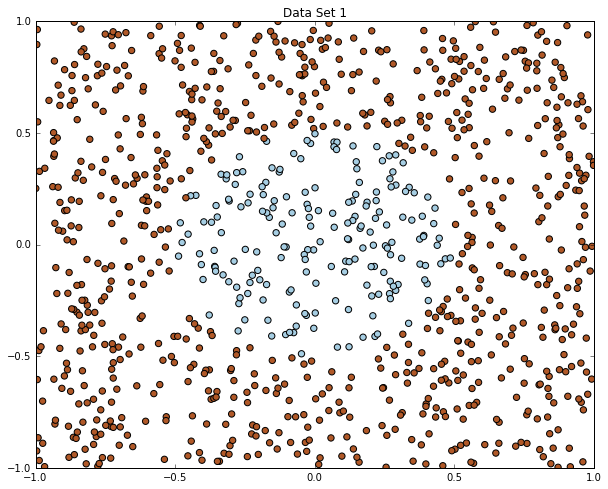

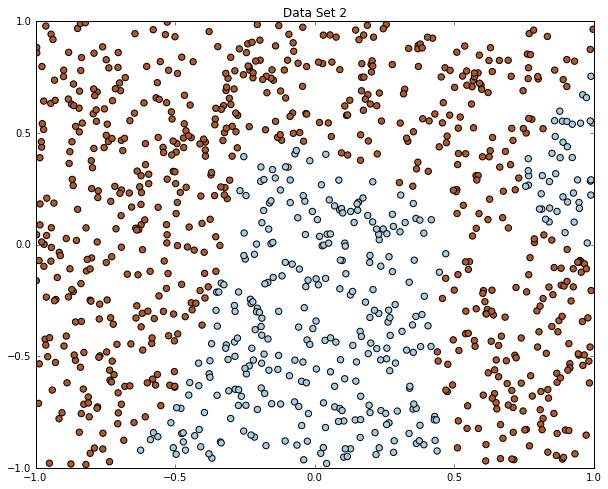

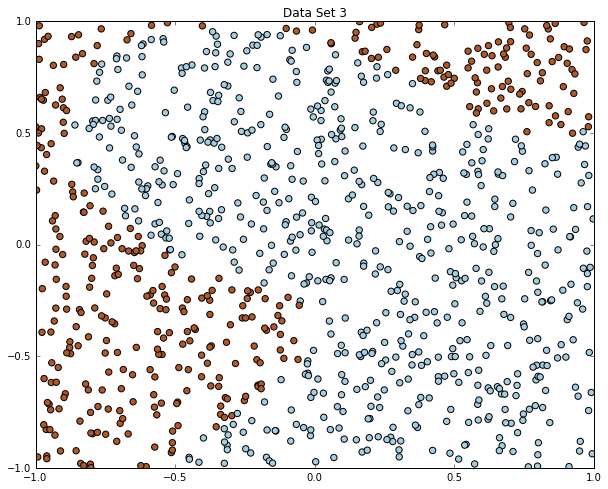

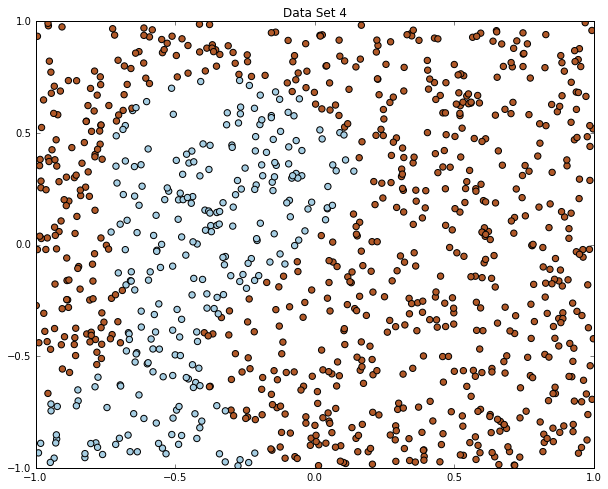

In [3]:
# Enable plotting directly in the notebook
%matplotlib inline
# import NumPy and MatplotLib pyplot
import numpy as np
import matplotlib.pyplot as plt

D = np.load("ex2_data.npz")
dsets = [(D['X%d' % i], D['y%d' % i]) for i in range(1, 5)]

for i, (X, y) in enumerate(dsets):
    # Insert code to plot the data sets here
    plt.figure(figsize=(10,8))
    plt.axis([-1,1,-1,1])
    plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.Paired,s=40)
    plt.title("Data Set {0}".format(i+1))

We will use the perceptron learning algorithm you implemented in last week's exercise. As you can see from your plots above, the data sets are not linearly separable as given.

## Task 2:
Since we may want to run the perceptron algorithm, you should modify your code to run for a limited number of iterations and return the best hyperplane found so far.

In [46]:
def pla_train(X, y, w=None, maxiter=2**16):
    """
    Perceptron learning algorithm
    """
    # if no starting vector is given we set it to the zero vector
    if w is None:
        w = np.zeros(X.shape[1])       
    # Run the perceptron iteration
    bestw = w
    besterr = X.shape[0]
    i = 0;
    while True:
        if i >= maxiter: break # limit number of iterations with maxiter
        hy = np.sign(np.dot(X,w.T))
        bad = np.nonzero(hy!=y)[0] # indexes of wrongly classified points
        err = np.size(bad) # number of wrongly classified points
        if err < besterr: # save the best w so far
            bestw = w
            besterr=err 
        if err == 0: break # perfect w
        idx = np.random.choice(bad)
        w = w + y[idx] * X[idx]
        i += 1
        #print(w, i)
    yield bestw
    yield besterr

## Task 3: 
We will also make use of your plot_hyperplane function from last week, so let's put it here.

In [39]:
# function to plot a hyperplane in 2D

def plot_hyperplane(w, *args, **kwargs): 
    if w[1]==0 and w[2]==0: raise ValueError('Invalid hyperplane')
    xmin,xmax,ymin,ymax=plt.axis()
    
    # Write code here to create two NumPy arrays x and y that contain the x and y coordinates
    # of the two endpoints of the line to be drawn.
    
    xbound = np.array((xmin,xmax))
    ybound = np.array((ymin,ymax))
    x = np.array((0,0))
    y = np.array((0,0))
    
    x = xbound
    if w[2] != 0:
        y = (w[0]*1 + w[1]*x) / -w[2]
        #y = np.clip(y, ymin, ymax)
    else:
        y = ybound
        x = (w[0]*1 + w[2]*y) / -w[1]
            
    if (not ((y[0] < ybound[0] and y[1] < ybound[0]) or (y[0] > ybound[1] and y[1] > ybound[1]))):
        if (not ((x[0] < xbound[0] and x[1] < xbound[0]) or (x[0] > xbound[1] and x[1] > xbound[1]))):
            plt.plot(x,y,*args,**kwargs)

We denote a feature transform by $\phi$. In the lectures we showed you a simple non linear transform that was able to separate a simple circular data set in feature space.  This was the transform $\phi(x_1,x_2) = (x_1^2,x_2^2)$.

## Task 4:

To get started we will focus on the first dataset. In fact, using the above feature transform, the data set will be linearly separable. Apply the transformation to the first dataset, run the perceptron learning algorithm on the transformed data, and plot the result.

Hyperplane:  [-1.          4.06190255  3.8621665 ]  with in-sample err:  0


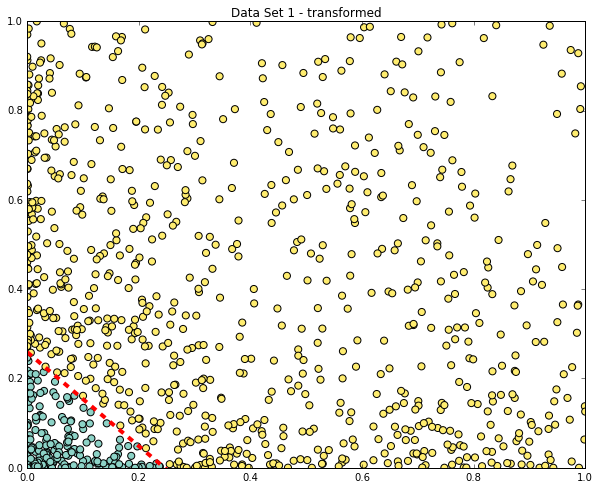

In [47]:
X = D['X1']
y = D['y1']

# Insert code here to transform the data - aim to make a vectorized solution!
Xt = np.array(( np.power(X[:,0],[2]), np.power(X[:,1],[2]) )).T
# Add a column of ones to the data
Xt = np.c_[np.ones(Xt.shape[0]),Xt]

plt.figure(figsize=(10,8))
plt.axis([Xt[:, 1].min(),Xt[:, 1].max(),Xt[:, 2].min(),Xt[:, 2].max()])
w_pla, err = pla_train(Xt,y,np.ones(3))
print('Hyperplane: ',w_pla, ' with in-sample err: ', err)
plt.scatter(Xt[:,1],Xt[:,2],c=y,cmap=plt.cm.Set3,s=50)
plot_hyperplane(w_pla,'r--',linewidth=4)    
plt.title('Data Set 1 - transformed')
plt.show()

# Contour plots

Now we are going to visualize the decision boundary in the original input space. That is, we need to plot the decision boundary under the inverse image of the feature transformation $\phi^{-1}$. When $\phi$ is not just a very simple transformation, this is not a very easy task. We will instead circumvent this difficulty and make use of contour plots.

Here is a simple example of a contour plot that plots $\phi^{-1}(0)$ in the input range $[-1,1] \times [-1,1]$, where $\phi(x,y) = x^4 - y^3 - xy$:

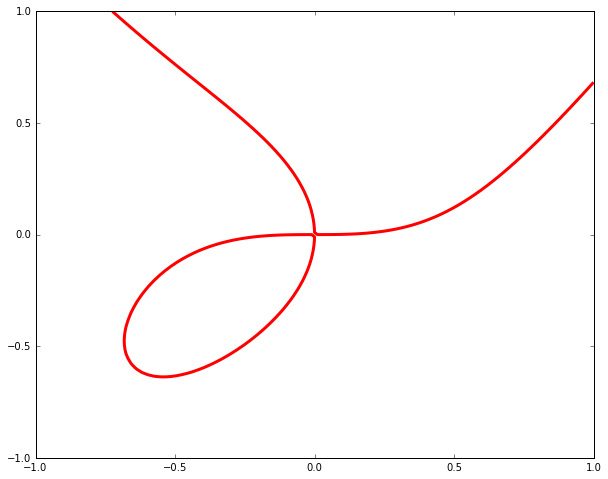

In [7]:
xs = ys = np.linspace(-1,1,100)
xm, ym = np.meshgrid(xs,ys)
zm = xm**4 - ym**3 - xm*ym  # Evaluate phi on x and y points
plt.figure(figsize=(10, 8))
# Plot the z = 0 contour:
plt.contour(xs, ys, zm, [0], colors='r', linewidths=3)

## Task 5:

Now that we know how to draw contour plots, we can go back to dataset 1. Draw the data set in their original input domain together with the decision boundary transformed back to the original input domain. With contour plots we just need to compute a matrix consiting of the entries $w_{pla} \cdot \phi(x,y)$, where $x$ and $y$ range over the x and y coordinates.

Aim to make a vectorized solution! There are different approaches to obtain this. If you have built coordinate grids as above using meshgrid, then xm and ym are $100 \times 100$ arrays. You can then build a $3 \times 100 \times 100$ array where the first index is indexing the coordinates of $\phi(x,y)$ (together with the dummy 1) and the other two indices are $x$ and $y$. Here the NumPy command <tt>array</tt> is useful. You can now either:
1. Reshape the array to a $3 \times 10000$ array, make a vector matrix product with $w_{pla}$ obtaining a $1 \times 10000$ array and reshaping back to a $100 \times 100$ array. For this the NumPy <tt>reshape</tt> function is useful.
2. Achieve the result directly using a tensor dot product. For this the NumPy <tt>tensordot</tt> function is useful.

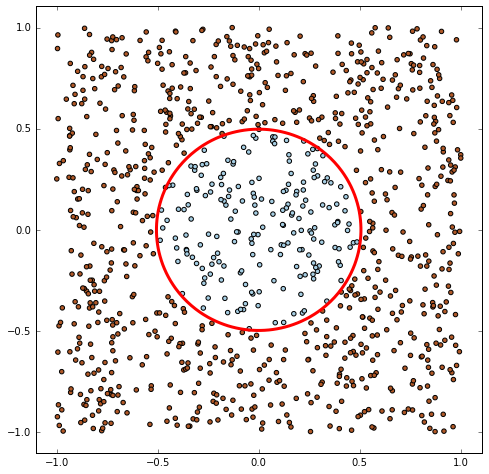

In [9]:
plt.figure(figsize=(8,8))
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.Paired,s=20)

# Insert code here to plot the decision boundary in the original input domain.
xs = ys = np.linspace(-1,1,100)
xm, ym = np.meshgrid(xs,ys)
zm = np.array((w_pla[0]*1 + w_pla[1] * xm**2 + w_pla[2] * ym**2))
plt.contour(xs, ys, zm, [0], colors='r', linewidths=3)


We are now ready to tackle the other datasets. With the simple transform $\phi$ above the datasets are not linearly seperable, but we can still try the modified version of the perceptron algorithm.

## Task 6:
Run the same experiment as above on the remaining datasets.

(1000, 3)
Dataset 2, hyperplane: [-1.          4.32873352  1.56633692], in-sample err.: 218
(1000, 3)
Dataset 3, hyperplane: [-2.          1.94723501  1.99278857], in-sample err.: 284
(1000, 3)
Dataset 4, hyperplane: [ 1.          0.60709766  0.44833686], in-sample err.: 260


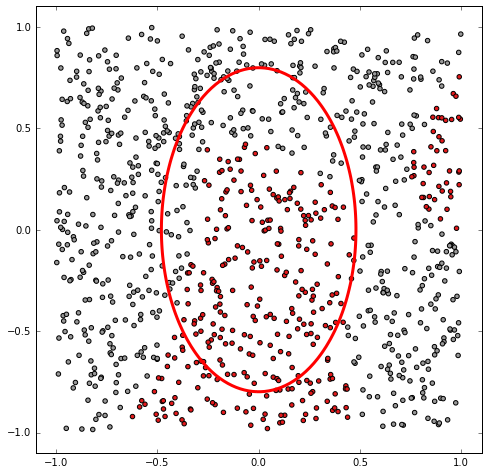

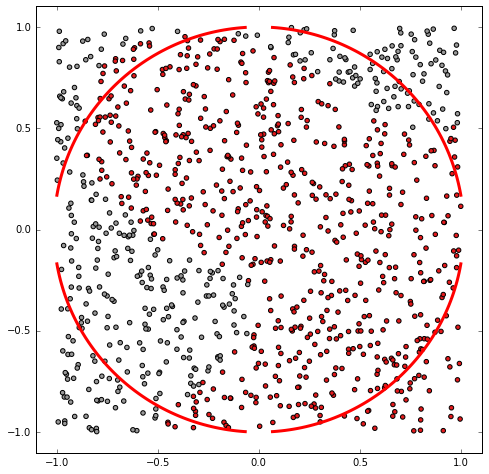

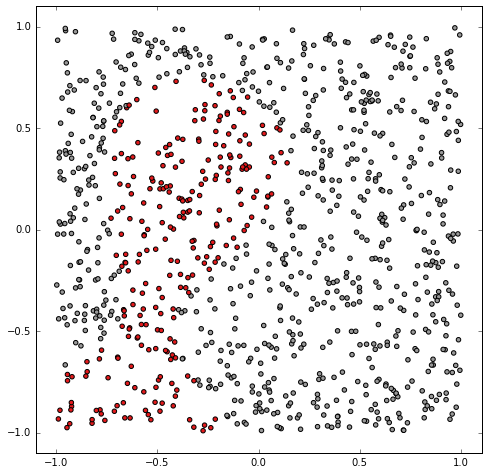

In [67]:
# Process data sets 2 to 4
for i in range(2, 5):
    X = D['X%d' % i]
    X = np.c_[np.ones(X.shape[0]), X] # add dummy coordinate
    y = D['y%d' % i]

    # Insert code that 
    # (1) processes the remaining datasets.
    plt.figure(figsize=(8,8))
    plt.scatter(X[:,1],X[:,2],c=y,cmap=plt.cm.Set1,s=20)

    # (2) applies the simple transform.
    Xt = np.array((np.power(X,[2, 2, 2]) ))

    # (3) runs the perceptron learning algorithm.
    w_pla, err = pla_train(Xt,y)
    print('Dataset %i, hyperplane: %s, in-sample err.: %s' % (i, w_pla, err))
    
    # (4) computes and prints the in sample error and plots the results.
    xs = ys = np.linspace(-1,1,100)
    xm, ym = np.meshgrid(xs,ys)
    zm = np.array((w_pla[0]*1 + w_pla[1] * xm**2 + w_pla[2] * ym**2))
    plt.contour(xs, ys, zm, [0], colors='r', linewidths=3)


Another approach which you must try is the come up with a better non-linear transform that makes the data linearly separable in the transformed space. We suggest (wink, wink) you use the general form of polynomials of degree 3, i.e.: $\phi(x_1,x_2) = (x_1^i \; x_2^j \quad \text{for} \quad 0 \leq i+j \leq 3)$. This should give $\binom{2+3}{3}=10$ features where one of them is the all ones vector. After that you can experiment with the degree 2 transform as well.

## Task 7:

Try to apply the transform to all the datasets, run the perceptron learning algorithm, and plot the results.

You may find Python's list comprehension useful as well as the numpy command vstack, for making concise vectorized code.

Dataset 1, hyperplane: [ -4.          -0.29849864  -0.41335183  15.79478651  -0.86268466
  15.5885638    1.7293606   -0.25092909  -0.67286743   1.03956099], in-sample err.: 0
Dataset 2, hyperplane: [ -7.           0.98462424  11.26540599  51.31447834   1.92937237
   2.04705204 -48.51389241 -56.63830004  37.29295782  22.46756583], in-sample err.: 0
Dataset 3, hyperplane: [ -9.           4.07626202 -39.48082838  14.11302009  66.8888068
 -12.60880412 -38.57556323  31.24635718 -28.67016874  72.42804524], in-sample err.: 0
Dataset 4, hyperplane: [  1.          42.7747799  -37.74147994  21.45892131 -15.83414541
  25.43227574 -47.9372597   25.89607319  29.7829631   54.08112287], in-sample err.: 0


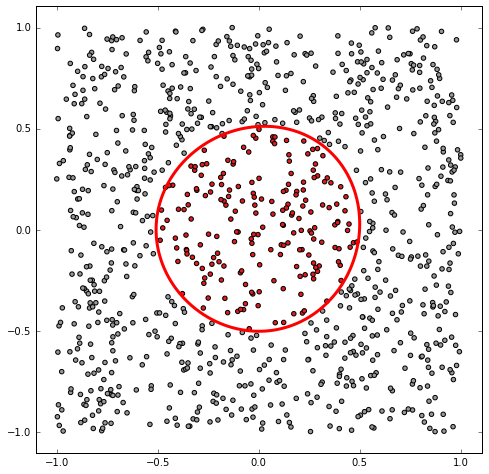

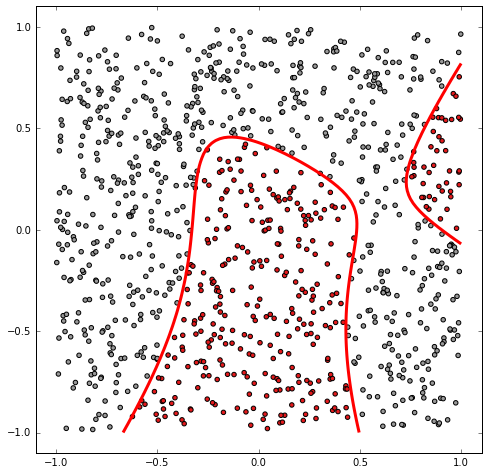

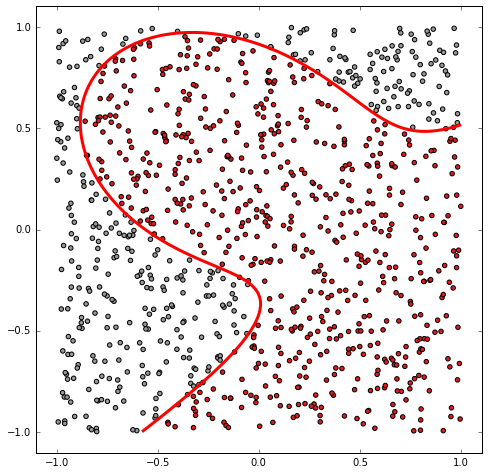

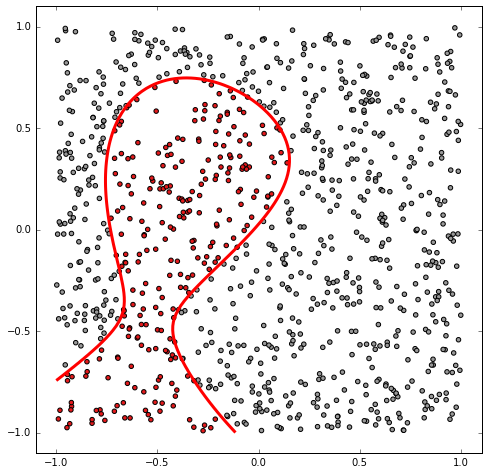

In [112]:
for i in range(1, 5):
    X = D['X%d' % i]
    y = D['y%d' % i]
    
    # Insert code that 
    # (1) processes the remaining datasets.
    X = np.c_[np.ones(X.shape[0]), X] # add dummy coordinate
    plt.figure(figsize=(8,8))
    plt.scatter(X[:,1],X[:,2],c=y,cmap=plt.cm.Set1,s=20)
    
    # (2) applies the degree 3 polynomial transform.
    Xt = X[:,[0, 0, 0, 0, 0, 0, 1, 1, 1, 2]] \
        *X[:,[0, 0, 0, 1, 1, 2, 1, 1, 2, 2]] \
        *X[:,[0, 1, 2, 1, 2, 2, 1, 2, 2, 2]]
        
    
    # (3) runs the perceptron learning algorithm.
    w_pla, err = pla_train(Xt,y)
    
    # (4) computes and prints the in sample error and plots the results.
    print('Dataset %i, hyperplane: %s, in-sample err.: %s' % (i, w_pla, err))
    
    xs = ys = np.linspace(-1,1,100)
    xm, ym = np.meshgrid(xs,ys)
    xm = np.reshape(xm,[xm.size])
    ym = np.reshape(ym,[ym.size])
    xplot = np.c_[np.ones(xm.shape), xm, ym]
    zm = w_pla.dot(
                (xplot[:,[0, 0, 0, 0, 0, 0, 1, 1, 1, 2]] \
                *xplot[:,[0, 0, 0, 1, 1, 2, 1, 1, 2, 2]] \
                *xplot[:,[0, 1, 2, 1, 2, 2, 1, 2, 2, 2]]).T \
                  ).reshape([xs.size, ys.size])
    plt.contour(xs, ys, zm, [0], colors='r', linewidths=3)